In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools
from matplotlib.ticker import ScalarFormatter
import mplfinance as mpf
from PIL import Image
import os

In [2]:
fire_path = 'fire_dataset/fire_images/'
non_fire_path = 'fire_dataset/non_fire_images/'

In [3]:
fire_images = [os.path.join(fire_path, fname) for fname in os.listdir(fire_path) if os.path.isfile(os.path.join(fire_path, fname))]
non_fire_images = [os.path.join(non_fire_path, fname) for fname in os.listdir(non_fire_path) if os.path.isfile(os.path.join(non_fire_path, fname))]

df_fire = pd.DataFrame({'img_path': fire_images, 'label': 1})
df_non_fire = pd.DataFrame({'img_path': non_fire_images, 'label': 0})

df = pd.concat([df_fire, df_non_fire], ignore_index=True)

df = df.sample(frac=1, random_state=42).reset_index(drop=True)


df.head(5)

,img_path,label
0,fire_dataset/fire_images/fire.507.png,1
1,fire_dataset/non_fire_images/non_fire.133.png,0
2,fire_dataset/fire_images/fire.288.png,1
3,fire_dataset/fire_images/fire.378.png,1
4,fire_dataset/fire_images/fire.86.png,1


In [4]:
df

,img_path,label
0,fire_dataset/fire_images/fire.507.png,1
1,fire_dataset/non_fire_images/non_fire.133.png,0
2,fire_dataset/fire_images/fire.288.png,1
3,fire_dataset/fire_images/fire.378.png,1
4,fire_dataset/fire_images/fire.86.png,1
...,...,...
994,fire_dataset/fire_images/fire.195.png,1
995,fire_dataset/fire_images/fire.342.png,1
996,fire_dataset/non_fire_images/non_fire.194.png,0
997,fire_dataset/fire_images/fire.491.png,1


In [ ]:
import numpy as np
from PIL import Image
from skimage.util import view_as_blocks
import cv2

def compute_cluster_feature(img_path, patch_size=16):
    try:
        img = Image.open(img_path)

        if img.mode == 'RGBA':
            img = img.convert('RGB')  
        img = img.convert("L") 

        img = img.resize((256, 256))
        img_np = np.array(img)

        blocks = view_as_blocks(img_np, block_shape=(patch_size, patch_size))
        
        bright_pixels = np.sum(blocks > 128, axis=(2, 3))

        return bright_pixels.flatten()
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None

def compute_color_histogram(img_path, bins=(8, 8, 8)):
    try:
        img = Image.open(img_path).convert('RGB')
        img = img.resize((256, 256))
        img_np = np.array(img)
        hist = cv2.calcHist([img_np], [0, 1, 2], None, bins, [0, 256]*3)
        hist = cv2.normalize(hist, hist).flatten()  

        return hist
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None

In [6]:
#df['cluster_feature'] = df['img_path'].apply(compute_cluster_feature_2, patch_size=8)
df['cluster_feature'] = df['img_path'].apply(compute_color_histogram)


In [7]:
df = df.dropna(subset=['cluster_feature'])
df

,img_path,label,cluster_feature
0,fire_dataset/fire_images/fire.507.png,1,"[0.8349651, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,fire_dataset/non_fire_images/non_fire.133.png,0,"[0.05483351, 0.028118113, 0.0, 0.0, 0.0, 0.0, ..."
2,fire_dataset/fire_images/fire.288.png,1,"[0.31112996, 6.5611544e-05, 0.0, 0.0, 0.0, 0.0..."
3,fire_dataset/fire_images/fire.378.png,1,"[0.4114273, 0.02187848, 0.0, 0.0, 0.0, 0.0, 0...."
4,fire_dataset/fire_images/fire.86.png,1,"[0.109499775, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
...,...,...,...
994,fire_dataset/fire_images/fire.195.png,1,"[0.0065943557, 0.008865745, 0.0, 0.0, 0.0, 0.0..."
995,fire_dataset/fire_images/fire.342.png,1,"[0.6042808, 0.0038579325, 0.0, 0.0, 0.0, 0.0, ..."
996,fire_dataset/non_fire_images/non_fire.194.png,0,"[0.55383074, 3.8234775e-05, 0.0, 0.0, 0.0, 0.0..."
997,fire_dataset/fire_images/fire.491.png,1,"[0.5211829, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [8]:
df['cluster_feature'][0].shape

(512,)

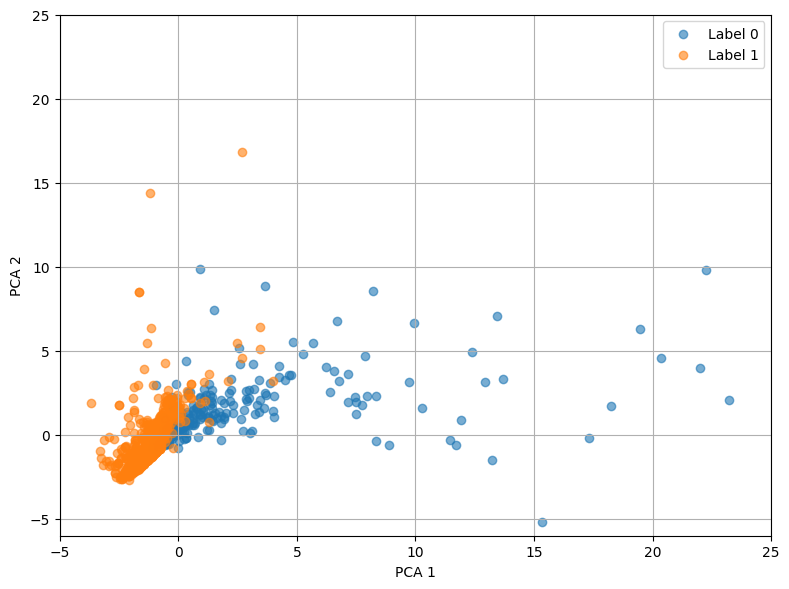

In [27]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

y = df['label'].values  
X_scaled = StandardScaler().fit_transform(np.vstack(df['cluster_feature'].values)  )

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
for label in np.unique(y):
    idx = y == label
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f'Label {label}', alpha=0.6)



plt.xlim(-5, 25)
plt.ylim(-6, 25)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

0.2899


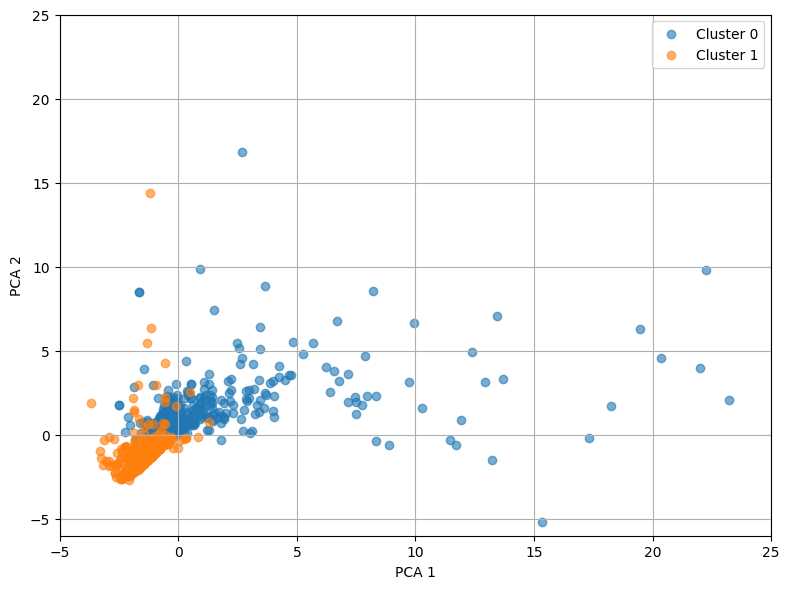

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

ari = adjusted_rand_score(df['label'], cluster_labels)
print(f"{ari:.4f}")

plt.figure(figsize=(8, 6))
for label in np.unique(cluster_labels):
    idx = cluster_labels == label
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f'Cluster {label}', alpha=0.6)
plt.xlim(-5, 25)
plt.ylim(-6, 25)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

0.0838


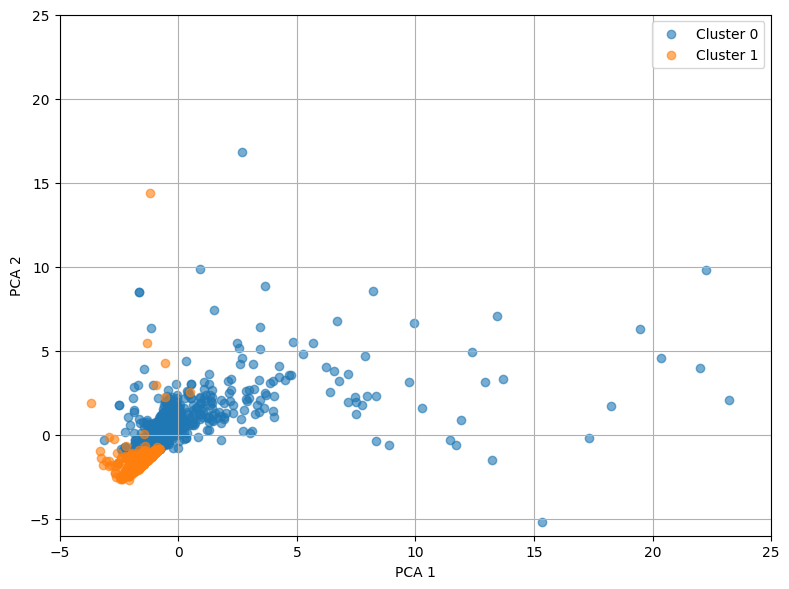

In [29]:
from sklearn.cluster import SpectralClustering

spectral = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=42)
cluster_labels = spectral.fit_predict(X_scaled)

df['spectral_cluster'] = cluster_labels
ari = adjusted_rand_score(df['label'], cluster_labels)
print(f"{ari:.4f}")


plt.figure(figsize=(8, 6))
for label in np.unique(cluster_labels):
    idx = cluster_labels == label
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f'Cluster {label}', alpha=0.6)
plt.xlim(-5, 25)
plt.ylim(-6, 25)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
X_scaled.shape

(999, 512)

0.4966


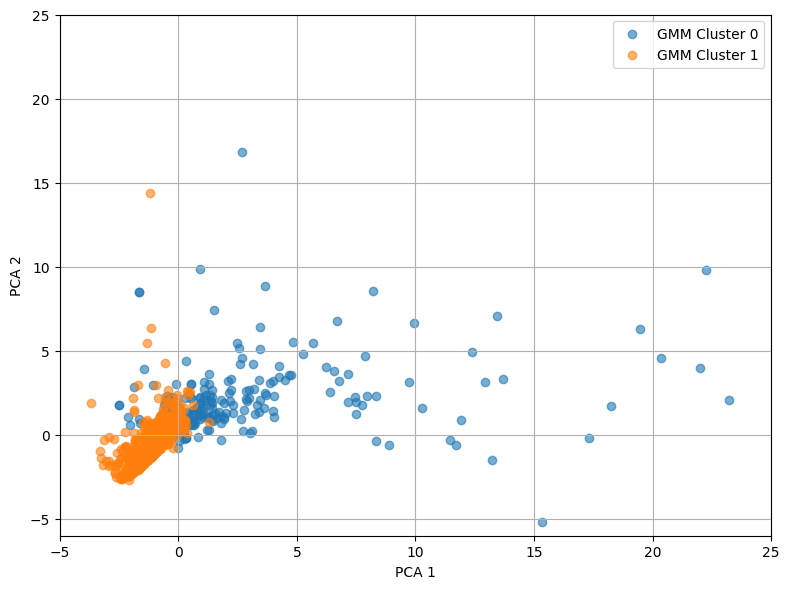

In [30]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=42, covariance_type='diag')
gmm_labels = gmm.fit_predict(X_scaled) 

df['gmm_cluster'] = gmm_labels
ari = adjusted_rand_score(df['label'], gmm_labels)
print(f"{ari:.4f}")

plt.figure(figsize=(8, 6))
for label in np.unique(gmm_labels):
    idx = gmm_labels == label
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f'GMM Cluster {label}', alpha=0.6)
plt.xlim(-5, 25)
plt.ylim(-6, 25)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
